In [1]:
import sys
sys.path.append("..")

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from models.utils import *
from models.vae import *
from models.scorenetwork import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import rotate
from itertools import chain
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import HTML
from IPython.display import clear_output

In [2]:
CUDA_VISIBLE_DEVICES = 0

# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)


# cuda = True if torch.cuda.is_available() else False
# FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
# torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = '../results/MNIST_CDAE'
model_dir = '../checkpoints/CDAE_MNIST'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)
con_train = False
load_available = True

In [3]:
joint_training = True
load_available = True
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 10
annealed_step = 100

select_t = 0.3

In [4]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../../Data/MNIST/',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

sigma =  5.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [5]:
vae = VAE(input_size=image_size, h_dim=h_dim, z_dim=z_dim, type='ce').to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# sn = SN_Model(device, n_steps, sigma_min, sigma_max, dim=z_dim, p = 0.3)
sn = SN_Model(marginal_prob_std=marginal_prob_std_fn, embed_dim=20, dim=z_dim, drop_p=0.3, num_classes=10, device=device)
sn_optim = torch.optim.Adam(sn.parameters(), lr = 0.005)
# dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)

joint_optim = torch.optim.Adam(params=chain(vae.parameters(), sn.parameters()))

# Start training
if con_train:
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device).view(-1, image_size)
            y = y.to(device)
            if joint_training:
                mu, log_var = vae.encode(x)
                z = vae.reparameterize(mu, log_var)
                x_reconst = vae.decode(z)
                # Compute reconstruction loss and kl divergence
                reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
                kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                loss_sn = sn.loss(z, y)
                loss = loss_sn + reconst_loss + kl_div

                joint_optim.zero_grad()
                loss.backward()
                joint_optim.step()
            else:
                #============= First Stage: Update VAE ==============#
                # Forward pass
                x_reconst, mu, log_var = vae(x)
                # Compute reconstruction loss and kl divergence
                # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
                reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
                kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                
                # Backprop and optimize
                vae_loss = reconst_loss + kl_div
                vae_optimizer.zero_grad()
                vae_loss.backward()
                vae_optimizer.step()

                #============= Second Stage: Update SN ==============#
                mu, log_var = vae.encode(x)
                z = vae.reparameterize(mu, log_var)

                loss_sn = sn.loss(z)
                vae_optimizer.zero_grad()
                sn_optim.zero_grad()
                loss_sn.backward()
                sn_optim.step()

            if (i+1) % 100 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Diffuse loss: {:.4f}"
                    .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), loss_sn.item()))

        with torch.no_grad():
            # Save the sampled images
            z = torch.randn(x.shape[0], z_dim).to(device)
            out = vae.decode(z).view(-1, 1, 28, 28)
            x_concat = torch.cat([x.view(-1, 1, 28, 28), out], dim=3)
            save_image(x_concat, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

            # Save the reconstructed images
            out, _, _ = vae(x)
            x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
            save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

            # Save the diffused ima ges
            # dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
            # z_ = forward_proc(z, sigma_min, sigma_max, n_steps, device=device, only_final=True)
            # sample = dynamic.sampling(x.shape[0], z_dim, sample=z_, only_final=True)

            z_ = forward_process(z, marginal_prob_std_fn, 100, device=device, end_t=select_t, only_final=True)
            sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=x.shape[0], y=y, num_steps=500, device=device, init_x=z_, start_t=select_t, only_final=True)

            # sample = dynamic.sampling(x.shape[0], z_dim, only_final=True)
            out = vae.decode(sample).view(-1, 1, 28, 28)
            x_concat = torch.cat([x.view(-1, 1, 28, 28), out], dim=3)
            save_image(x_concat, os.path.join(sample_dir, 'diffuse-{}.png'.format(epoch+1)))
    torch.save({'sn_state':sn.state_dict(), 'vae_state':vae.state_dict()}, model_dir+'ckpt.pth')


In [6]:
if load_available:
    ckpt = torch.load(model_dir+'ckpt.pth', map_location=device)
    vae = VAE(input_size=image_size, h_dim=h_dim, z_dim=z_dim, type='ce').to(device)
    sn = SN_Model(marginal_prob_std=marginal_prob_std_fn, embed_dim=20, dim=z_dim, drop_p=0.3, num_classes=10, device=device)
    vae.load_state_dict(ckpt['vae_state'])
    sn.load_state_dict(ckpt['sn_state'])

In [7]:
_, (x, y) = next(enumerate(data_loader))
x = x.to(device)
y = y.to(device)

In [8]:
def ani_imshow(sample, sampling_number = 64):

    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255

    show_sample = show_sample.astype(np.uint8)

    return show_sample

/home/oem/Documents/wangxu/LSGM-demo/notebooks/../models/scorenetwork.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


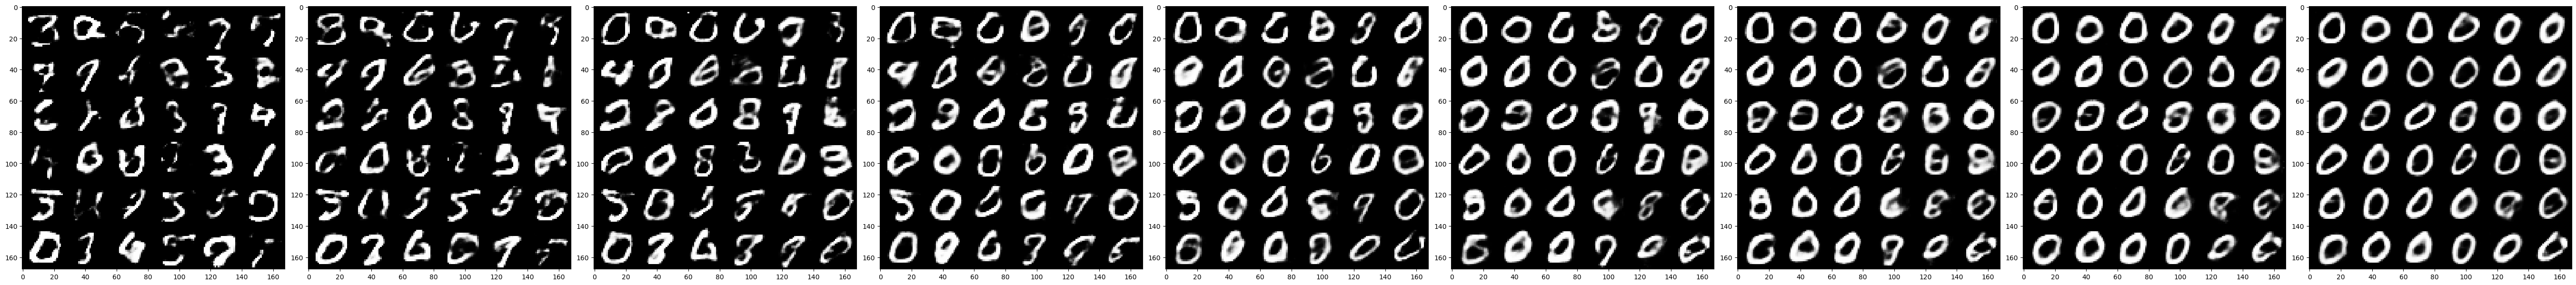

In [9]:
only_final = False
n_steps = 8
test_size = 36
# dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
# sample = dynamic.sampling(test_size, z_dim, only_final=False)
sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=test_size, num_steps=500, device=device, only_final=False)
diffuse_data = vae.decode(sample)

step_size = sample.size(0)
fig, axs = plt.subplots(1, step_size, figsize=(step_size * 6, 6), constrained_layout = True)
for i in range(step_size):
    diff_data = diffuse_data[i].view(-1, 1, 28, 28)
    axs[i].imshow(ani_imshow(diff_data, sampling_number = test_size), animated=True, cmap = 'gray')
    # plt.show()

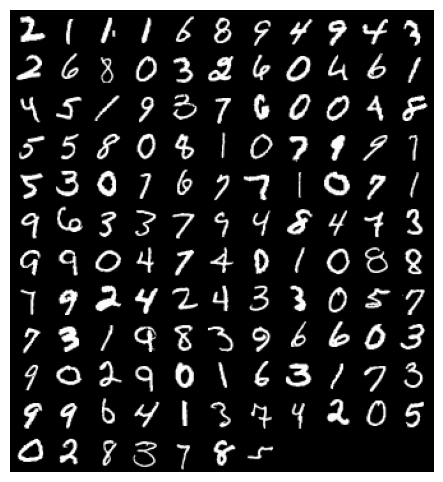

In [10]:
from torchvision.utils import make_grid

sample_grid = make_grid(x.view(-1, 1, 28, 28), nrow=int(np.sqrt(x.shape[0])))

select_t = 0.3

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [11]:
mu, log_var = vae.encode(x.view(-1, image_size))
z = vae.reparameterize(mu, log_var)
z_ = forward_process(z, marginal_prob_std_fn, 100, device=device, end_t=select_t, only_final=True)

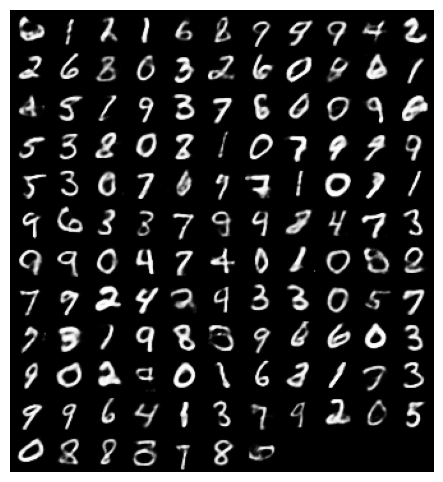

In [12]:
sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=z_.shape[0], y=y, num_steps=100, device=device, start_t=select_t, only_final=True, init_x=z_)

diffuse_data = vae.decode(sample)

from torchvision.utils import make_grid

sample_grid = make_grid(diffuse_data.view(-1, 1, 28, 28), nrow=int(np.sqrt(x.shape[0])))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

Number of function evaluations: 5144


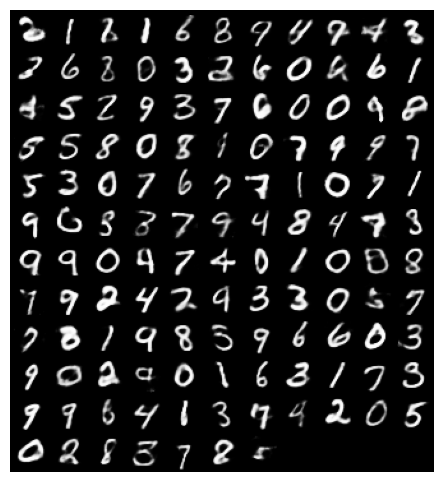

In [13]:
## ODE sampler

sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
z_ode = sampler(sn,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            batch_size=128,
            device=device,
            z=z_,
            y=y,
            start_t=select_t)
samples = vae.decode(z_ode.float()).view(-1, 1, 28, 28)
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

### The changes of one sample

In [14]:
recon_x, _, _ = vae(x.view(-1, image_size)[1])

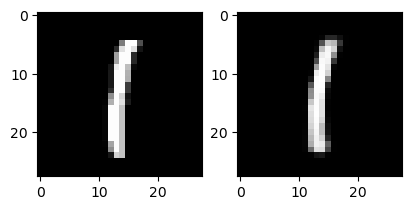

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 2, 2), constrained_layout = True)
axs[0].imshow(ani_imshow(x[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[1].imshow(ani_imshow(recon_x.view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')

In [16]:
mu, log_var = vae.encode(x.view(-1, image_size)[1])
z = vae.reparameterize(mu, log_var)

z_ = forward_process(z, marginal_prob_std_fn, num_steps=10, device=device, end_t=1., only_final=False)
recon_x_seq = vae.decode(z_).clamp(0.0, 1.0)

Text(0.5, 1.0, 'Forward process in latent space and its reconstruction')

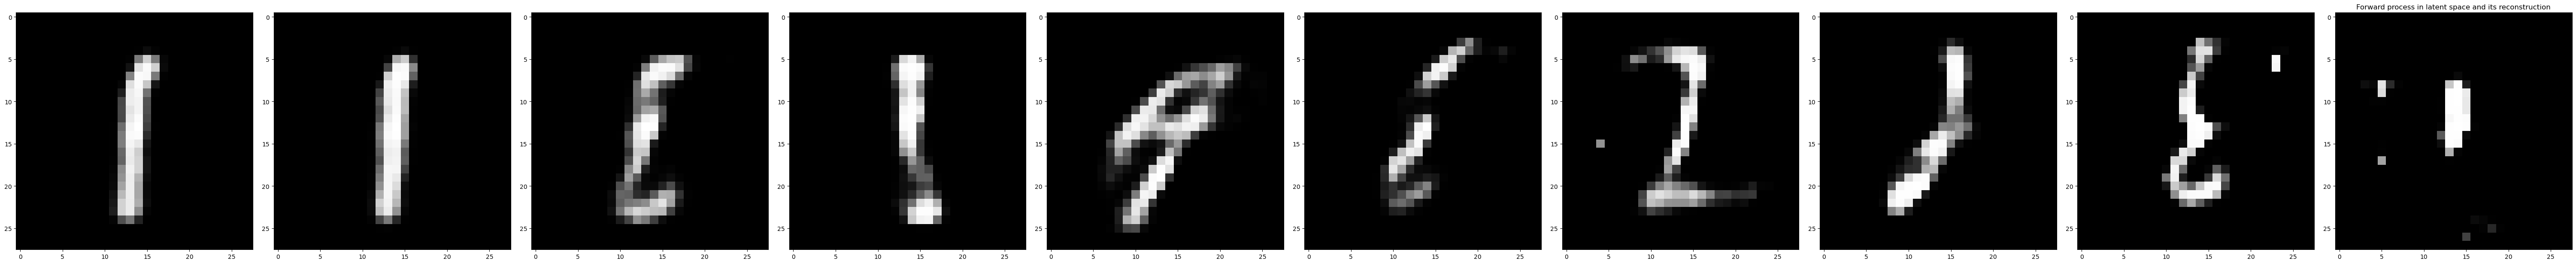

In [17]:
fig, axs = plt.subplots(1, recon_x_seq.shape[0], figsize=(recon_x_seq.shape[0] * 6, 6), constrained_layout = True)
for i in range(recon_x_seq.shape[0]):
    diff_data = recon_x_seq[i].view(-1, 1, 28, 28)
    axs[i].imshow(ani_imshow(diff_data, sampling_number = 1), animated=True, cmap = 'gray')
plt.title('Forward process in latent space and its reconstruction')

In [19]:
sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=1, num_steps=500, device=device, save_times=10, start_t=1., only_final=False, init_x=z_[-1], y=torch.tensor([1]).to(device))
# sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=1, num_steps=500, device=device, save_times=10, start_t=1., only_final=False)0
diffuse_data = vae.decode(sample)

Text(0.5, 1.0, 'Reverse process in latent space and its reconstruction')

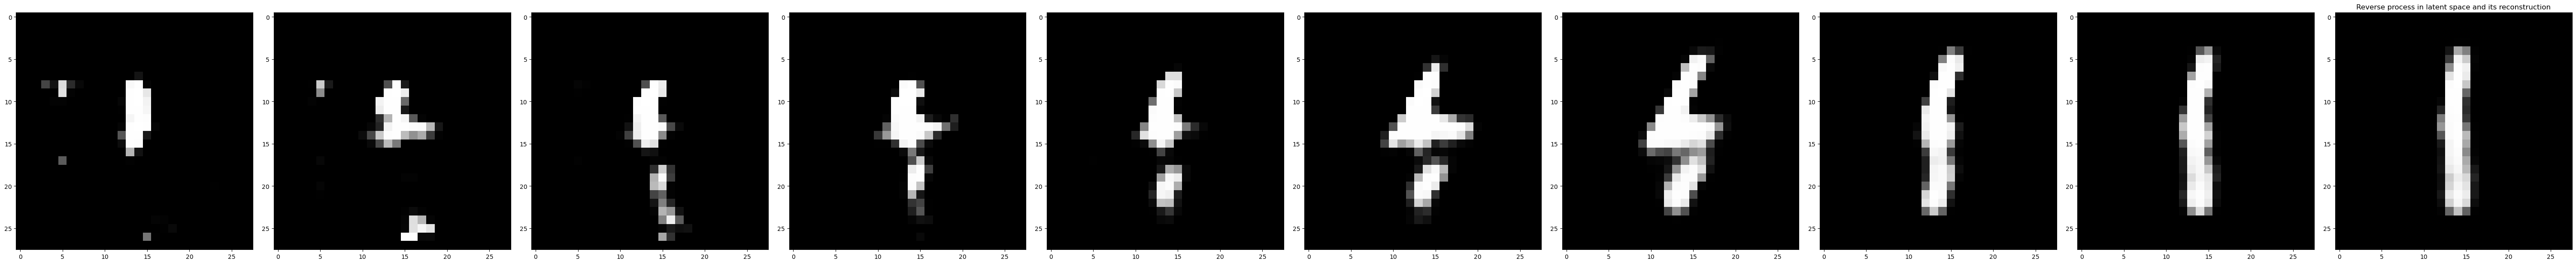

In [20]:
step_size = diffuse_data.shape[0]
fig, axs = plt.subplots(1, step_size, figsize=(step_size * 6, 6), constrained_layout = True)
for i in range(step_size):
    diff_data = diffuse_data[i].view(-1, 1, 28, 28)
    axs[i].imshow(ani_imshow(diff_data, sampling_number = 1), animated=True, cmap = 'gray')
plt.title('Reverse process in latent space and its reconstruction')

In [21]:
_, (x, y) = next(enumerate(data_loader))
x = x.to(device)
y = y.to(device)

mu, log_var = vae.encode(x.view(-1, image_size))
z = vae.reparameterize(mu, log_var)

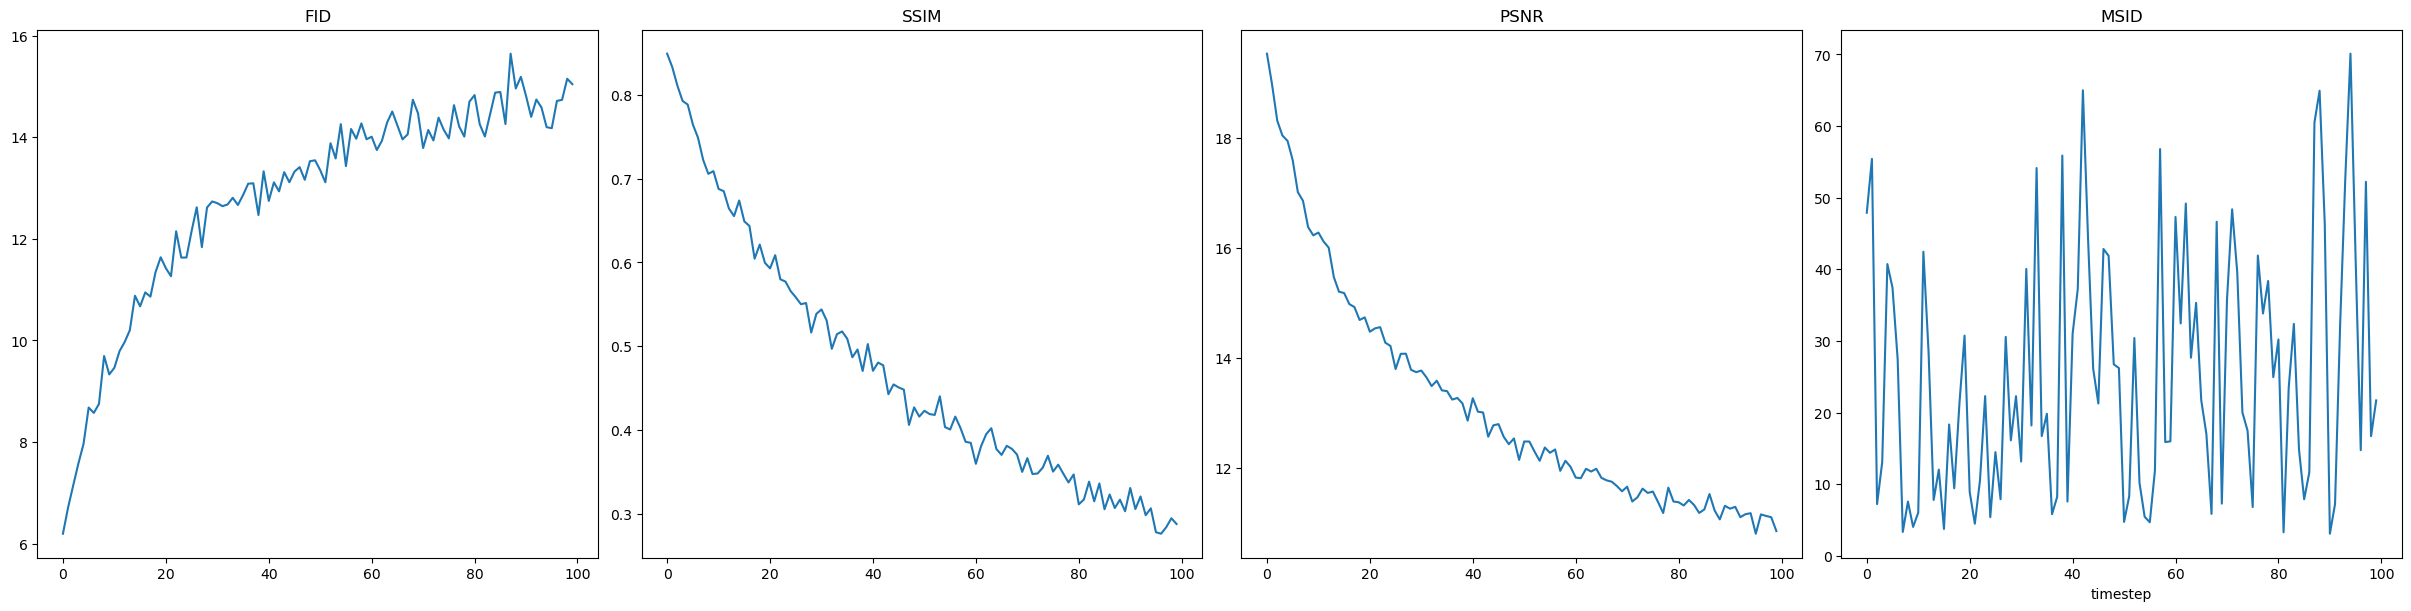

In [22]:
# FID 
from piq import FID, ssim, psnr, MSID, LPIPS

metrics = ['FID', 'SSIM', 'PSNR', 'MSID']
fig, axs = plt.subplots(1, len(metrics), figsize=(len(metrics) * 6, 6), constrained_layout = True)
i = 0
for metric in metrics:
    if metric == 'FID':
        metric_fn = FID()
    elif metric == 'SSIM':
        metric_fn = ssim
    elif metric == 'PSNR':
        metric_fn = psnr
    elif metric == 'MSID':
        metric_fn = MSID()
    
    idx_list = []


    for t in np.linspace(0.01, 1, 100):
        z_ = forward_process(z, marginal_prob_std_fn, num_steps=10, device=device, end_t=t, only_final=True)
        sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=x.shape[0], num_steps=500, device=device, save_times=10, start_t=t, only_final=True, init_x=z_, y=y)
        data_sample = vae.decode(sample).view(-1, 1, 28, 28).detach()
        if metric in ['MSID', 'FID']:
            idx_list.append(metric_fn(x.view(-1, 28*28), data_sample.view(-1, 28*28)).item())
        else:
            idx_list.append(metric_fn(x, data_sample).item())
    
    axs[i].plot(idx_list)
    axs[i].set_title(metric)
    i = i + 1
plt.xlabel('timestep')
plt.show()